<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
try:
    initial_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    raise Exception('Something is wrong. Check the file')

### Знакомство с данными

In [4]:
initial_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы видим, что в датасете есть два признака: временной ряд и кол-во заказов. Соответственно, это будет признаком и целевым признаком. Но перед этим нужно провести предобработку данных, а именно:
- ресемплировать на один час (сейчас 10 минут)
- отсортировать по возрастанию времени, временной ряд должен быть хронологически последовательным
- проверить на пропуски и аномалии

In [6]:
# оставим первоначальный датасет без изменений
data = initial_data.copy()

### Предобработка данных

In [7]:
# проверим наличие пропусков
data.isna().sum().sum()

0

In [8]:
# оценим возможные аномалии в количестве заказов
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Ничего необычного.

In [9]:
# отсортируем по времени
data.sort_index(inplace=True)

In [10]:
# ресемплируем на 1 час
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


С предобработкой данных мы закончили. Переходим к анализу.

## Анализ

Проведем минимальный EDA, чтобы проанализировать имеющиеся данные.

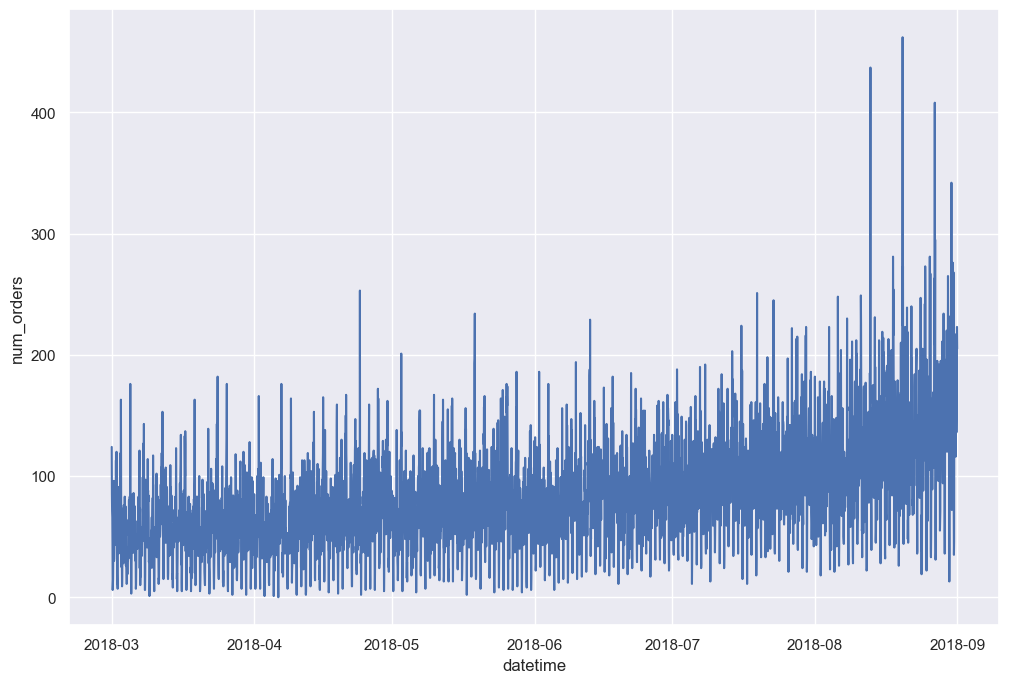

In [11]:
# взглянем на график
sns.lineplot(x='datetime', y='num_orders', data=data);

У нас имеются данные март-сентябрь 2018 года. Однако в таком виде всё слишком сливается. Изменим для визуализации ресемплирование.

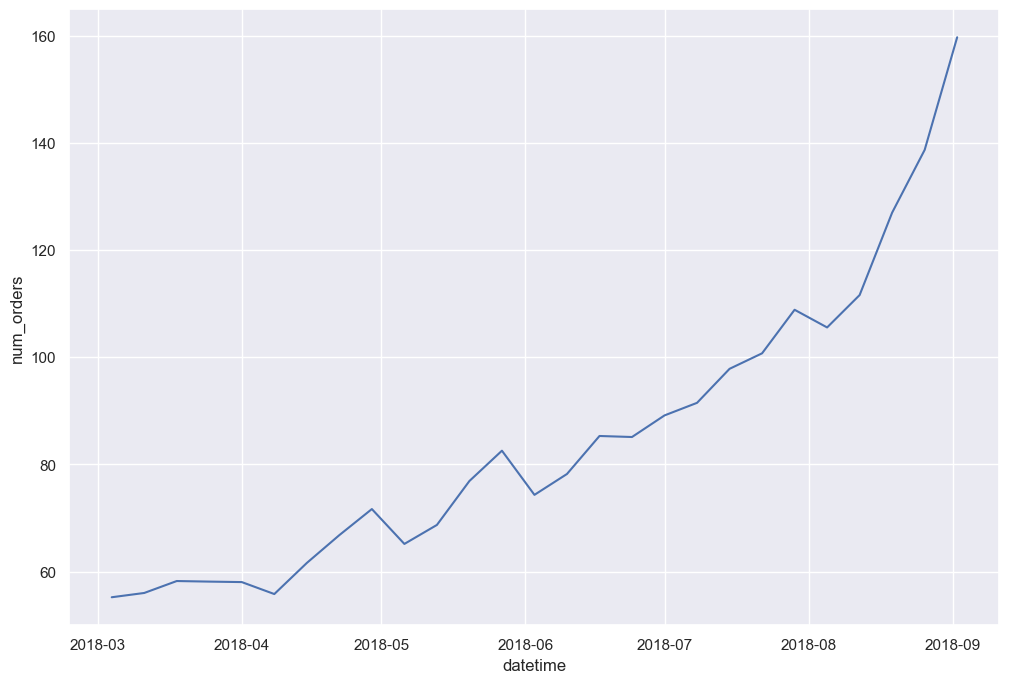

In [12]:
sns.lineplot(x='datetime', y='num_orders', data=data.resample('1W').mean());

Видим, что в среднем с весны по осень количество заказов такси повышается. Можно предположить, что эта тенденция будет продолжаться и дальше. Дополнительно взглянем со скользящим средним.

In [13]:
data['rolling_mean'] = data.rolling(24).mean()

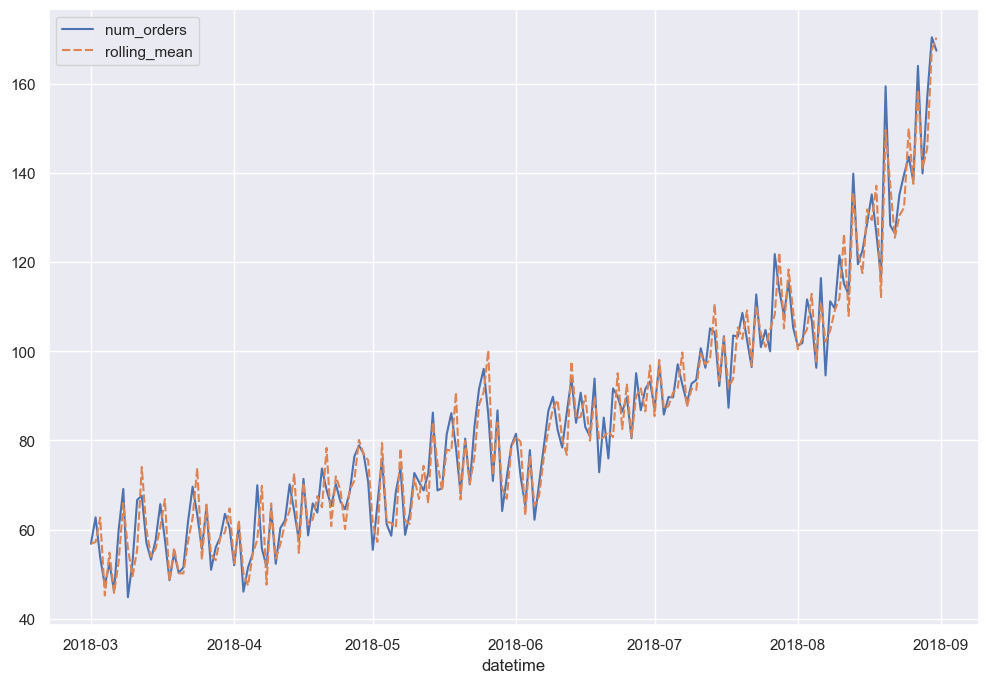

In [14]:
sns.lineplot(data=data.resample('1D').mean());

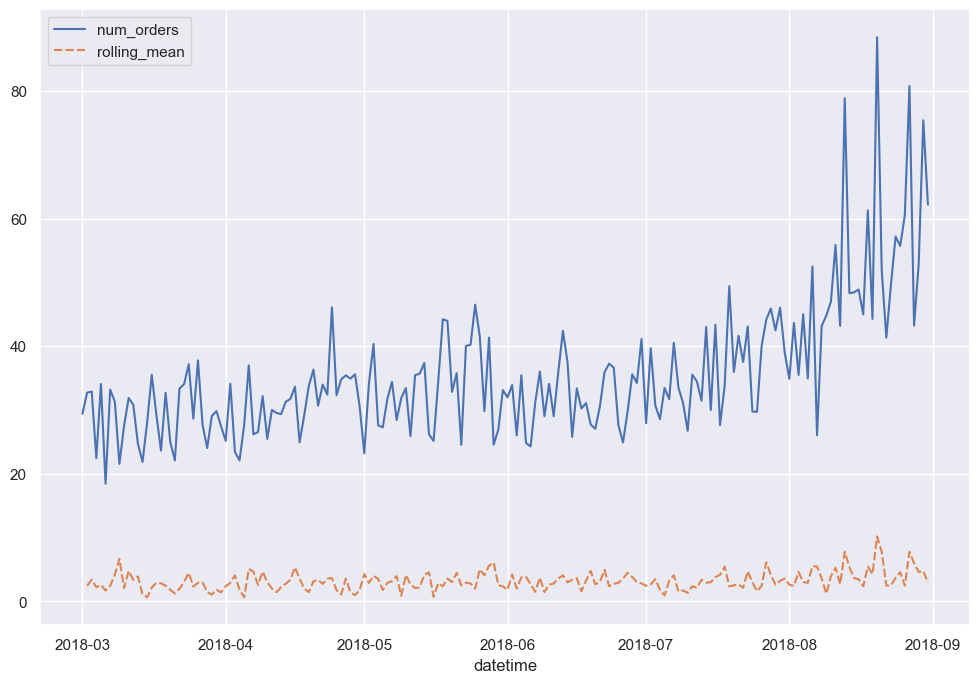

In [15]:
# взглянем на изменение скользящего стандартного отклонения
sns.lineplot(data=data.resample('1D').std());

Можно заметить, что имеется тренд на повышение кол-ва заказов. О сезонности сказать ничего нельзя, так как не хватает данных. Учитывая видимые на графиках изменения, можно утверждать, что перед нами нестационарный процесс.

In [16]:
# посмотрим статистику по дня недели и часам в сутках
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

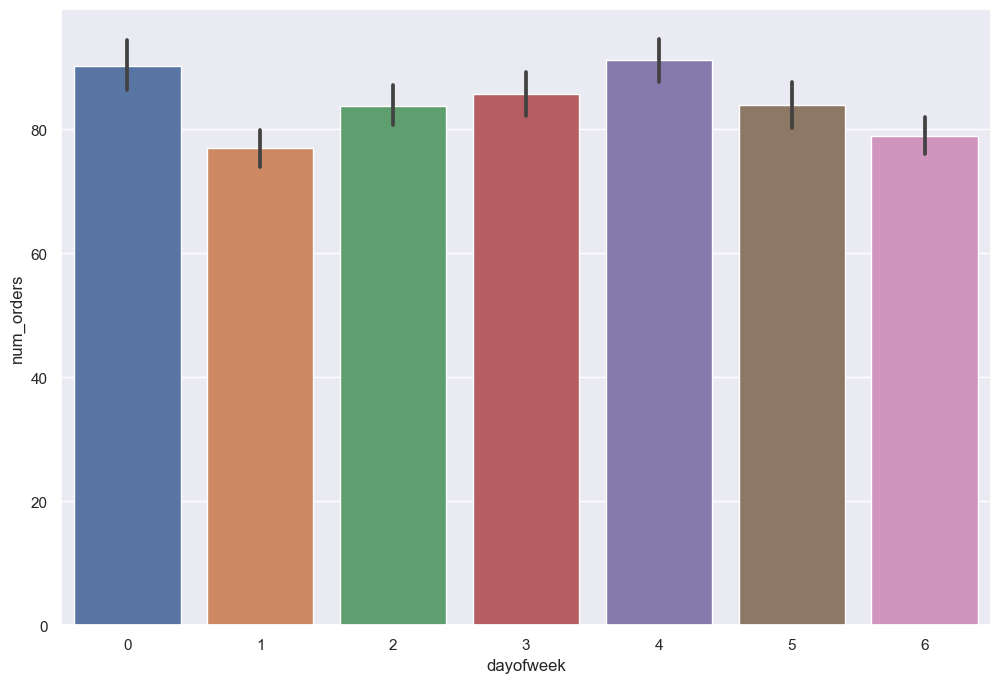

In [17]:
sns.barplot(data=data, x='dayofweek', y='num_orders');

Больше всего такси заказывали в понедельник и пятницу, а меньше всего во вторник.

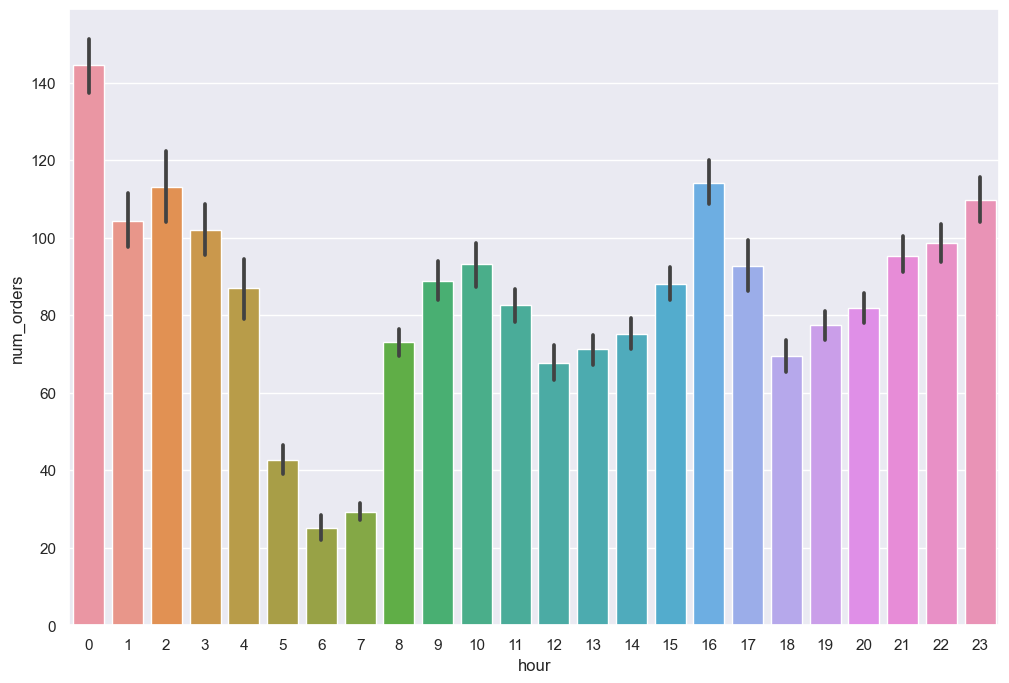

In [18]:
sns.barplot(data=data, x='hour', y='num_orders');

Больше всего заказов в первый час ночи, а меньше — в шесть утра. Трудно сказать точно, с чем это связано, стоит проверить заказы в начале суток. Также неизвестно, в какой таймзоне выгружены данные относительно региона такси. Но есть логика в том, что в промежутке 8-10 спрос возрастает, так как люди едут на работу, а также возрастает под вечер.

In [19]:
data = data.drop(['rolling_mean', 'dayofweek', 'hour'], axis=1)

In [20]:
decomposed = seasonal_decompose(data)

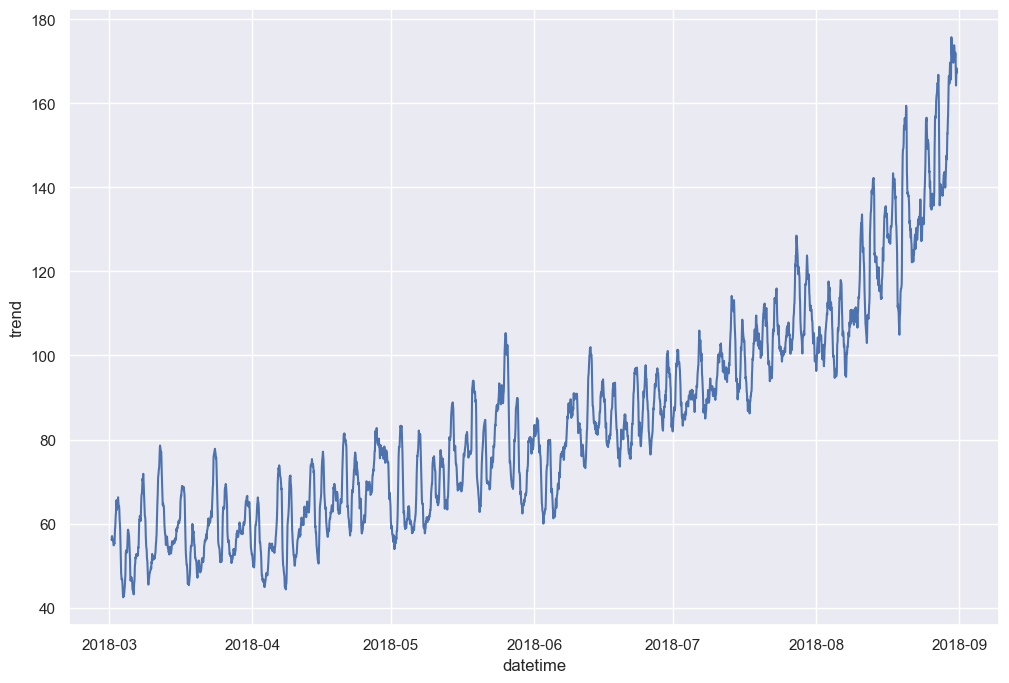

In [21]:
sns.lineplot(data=decomposed.trend);

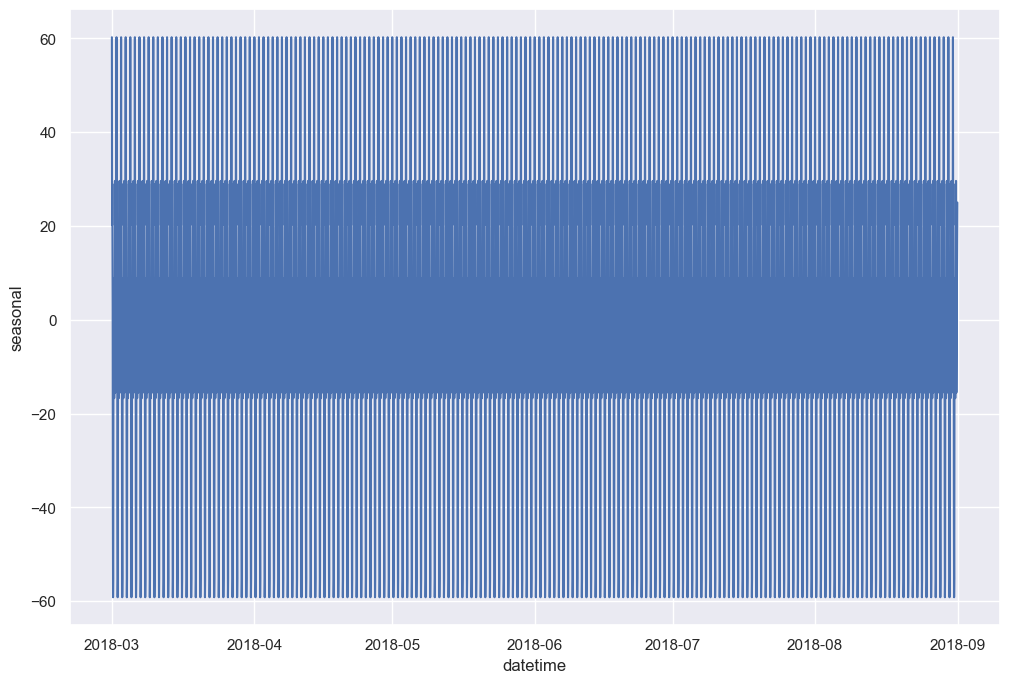

In [22]:
sns.lineplot(data=decomposed.seasonal);

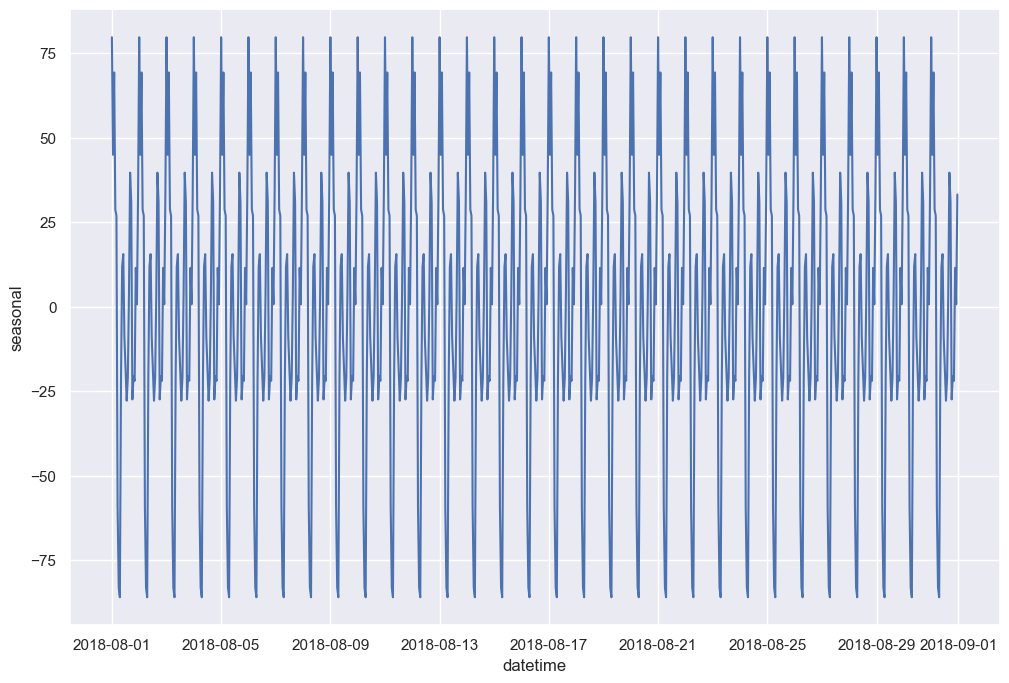

In [23]:
decomposed_short = seasonal_decompose(data['2018-08':'2018-09'])
sns.lineplot(data=decomposed_short.seasonal);

## Обучение

### Подготовка данных

Сейчас мы обучим несколько разных моделей для прогнозирования кол-ва заказов на следующий час. Мы будем предсказывать количественное значение и используем для этого регрессию. Однако нужна дополнительная подготовка:
- подготовка доп. признаков
- разделение признаков
- разделение на выборки

In [24]:
def make_features(data, lag, rolling_size):
    '''Функция добавляет в датафрейм
    признаки времени, лага и скользящего среднего'''
    df = data.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    
    return df

In [25]:
# добавляем признаки
data_features = make_features(data, 5, 5)
# убираем NaN значения
data_features = data_features.dropna()

In [26]:
data_features.head()

,num_orders,dayofweek,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,3,3,1,5,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,3,3,1,6,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,3,3,1,7,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,3,3,1,8,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,3,3,1,9,34.0,15.0,12.0,6.0,43.0,22.0


In [27]:
# обозначим единый рандом для всей дальнейшей работы
RANDOM_STATE = 999

In [28]:
# признаки
features = data_features.drop(['num_orders'], axis=1)
target = data_features['num_orders']

In [29]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, shuffle=False, test_size=0.4)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(2381, 10)
(1588, 10)
(442, 10)
(2381,)
(1588,)
(442,)


In [30]:
# скалируем все значения, так как они различаются
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train))
features_valid = pd.DataFrame(scaler.transform(features_valid))
features_test = pd.DataFrame(scaler.transform(features_test))

features_train.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.002112,-1.214658,-1.546374,-0.938173,-0.686386,0.013989,0.165595,0.591396,1.777930,0.541565
1,-0.002112,-1.214658,-1.546374,-0.793629,-1.812869,-0.686272,0.013292,0.164741,0.589978,-0.503900
2,-0.002112,-1.214658,-1.546374,-0.649084,-1.630196,-1.812780,-0.687300,0.012364,0.163534,-1.150670
3,-0.002112,-1.214658,-1.546374,-0.504540,-1.538860,-1.630103,-1.814340,-0.688569,0.011232,-1.646823
4,-0.002112,-1.214658,-1.546374,-0.359995,-0.960395,-1.538764,-1.631577,-1.816156,-0.689355,-1.930339


Сейчас мы последовательно обучим несколько моделей (линейной регрессии и градиентного бустинга), чтобы найти ту, которая покажет наименьшее RMSE.

In [31]:
# создадим объекта сплита временного ряда
tscv = TimeSeriesSplit()

### Линейная регрессия

In [32]:
model = LinearRegression()
model.fit(features_train, target_train)
pred = model.predict(features_valid)
print('RMSE', mean_squared_error(target_valid, pred, squared=False))

RMSE 35.64827834406122


### Ridge

In [33]:
model_ridge = Ridge(random_state=RANDOM_STATE)

# гиперпараметры
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv
)

gs_ridge.fit(features_train, target_train)

# лучшее значение RMSE
print(f'Best RMSE: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Best parameters: {gs_ridge.best_params_}')

Best RMSE: 28.036196467291035
Best parameters: {'alpha': 0.2}


### CatBoost

In [34]:
model_cat = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', random_state=RANDOM_STATE)
params_cat = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
grid_search_cat = GridSearchCV(model_cat, params_cat, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)
grid_search_cat.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

# Вывод лучших параметров и значения RMSE
print(f'Best parameters: {grid_search_cat.best_params_}')
print(f'Best RMSE: {-grid_search_cat.best_score_}')

Best parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best RMSE: 25.275817310270504


### LightGBM

In [35]:
params_gbm = [{
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}]

# Создание модели
model_gbm = LGBMRegressor(random_state=RANDOM_STATE)

# Поиск лучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(model_gbm, params_gbm, scoring='neg_root_mean_squared_error', cv=tscv)
grid_search.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))

# Вывод лучших параметров и значения RMSE
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best RMSE: {-grid_search.best_score_}')

Best parameters: {'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 50, 'objective': 'regression'}
Best RMSE: 25.292538174463274


Незначительно, но CatBoost показал наилучший результат. Проверим на тестовой выборке эту модель с уже подобранными гиперпараметрами.

## Тестирование

In [36]:
model_cat_final = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', depth=6,
                                    iterations=200, l2_leaf_reg=1, learning_rate=0.1, random_state=RANDOM_STATE)
model_cat_final.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
preds_cat = model_cat_final.predict(features_test)
print('RMSE', mean_squared_error(target_test, preds_cat, squared=False))

RMSE 45.24760751577233


In [37]:
# посмотрим на временной ряд истинных и предсказанных значений
true_pred_comparison = pd.DataFrame(target_test)
true_pred_comparison = true_pred_comparison.rename(columns={'num_orders': 'y_true'})
true_pred_comparison['y_pred'] = preds_cat

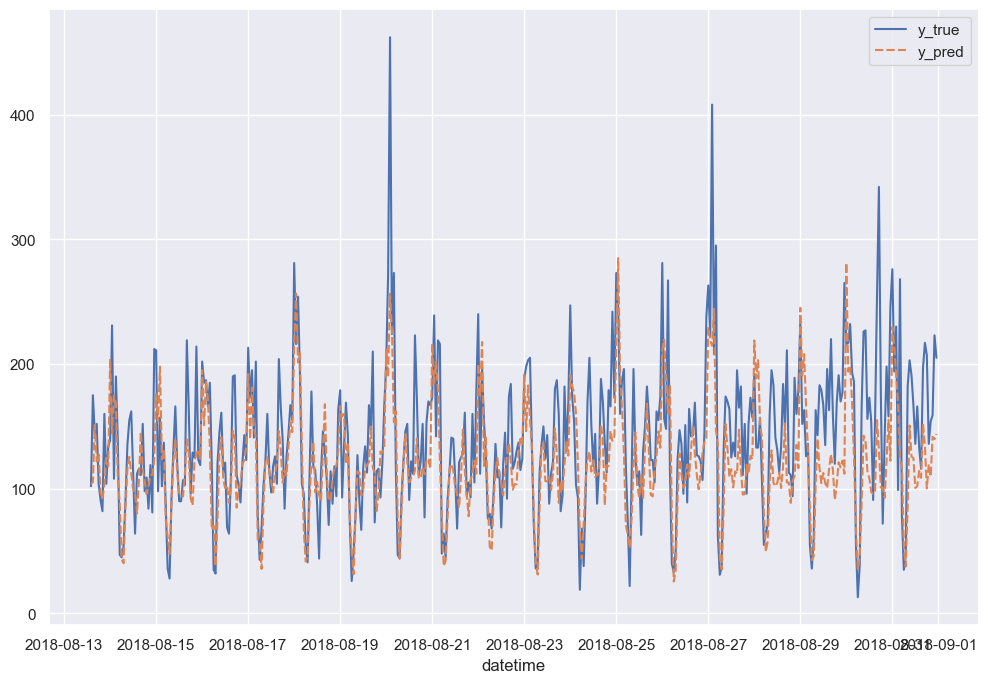

In [38]:
sns.lineplot(data=true_pred_comparison);

## Вывод

В ходе данного исследования мы стремились построить модель, которая будет прогнозировать кол-во заказов такси по временному ряду за шесть месяцев 2018 года на следующий час. Мы выделили нужные признаки, разбили на метрики, а после построили 4 модели, две из которых - линейная регрессия, а две другие — градиентный бустинг регрессии. Наилучший результат показал CatBoost со следующим RMSE:
1. Обучающая выборка — **25.3**
2. Тестовая выборка (10% от генеральной) — **45.2**

Полученный результат находится в допустимых пределах качества, а ухудшение качества может быть связано с тем, что временной ряд имеет нестационарный процесс, подверженный большим изменениям.